In [12]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import random
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

In [13]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset))

## Load the Dataset

In [14]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
  """Loads the IMDb movie reviews sentiment analysis dataset.

  # Arguments
    data_path: string, path to the data directory.
    seed: int, seed for randomizer

  # Returns
    A tuple of training and validation data.
    Number of training samples: 25000
    Number of test samples: 25000
    Number of categories: 2 (0 - negative, 1 - positive)

  # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
  """
  imdb_data_path = os.path.join(data_path, 'aclImdb')

  # Load the training data
  train_texts = []
  train_labels = []
  for category in ['pos', 'neg']:
    train_path = os.path.join(imdb_data_path, 'train', category)
    for fname in sorted(os.listdir(train_path)):
      if fname.endswith('.txt'):
        with open(os.path.join(train_path, fname)) as f:
          train_texts.append(f.read())
        train_labels.append(0 if category == 'neg' else 1)
  
  # Load the test data.
  test_texts = []
  test_labels = []
  for category in ['pos', 'neg']:
    test_path = os.path.join(imdb_data_path, 'test', category)
    for fname in sorted(os.listdir(test_path)):
      if fname.endswith('.txt'):
        with open(os.path.join(test_path, fname)) as f:
          test_texts.append(f.read())
        test_labels.append(0 if category == 'neg' else 1)

  # Shuffle the training data and labels.
  random.seed(seed) 
  random.shuffle(train_texts)
  random.seed(seed)
  random.shuffle(train_labels)

  return ((train_texts, np.array(train_labels)),
          (test_texts, np.array(test_labels)))

In [15]:
data = load_imdb_sentiment_analysis_dataset(dataset_dir)

In [16]:
(train_texts, train_labels), (test_texts, test_labels) = data

In [17]:
train_texts[0]

"POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disregarded some o

In [18]:
train_labels[0]

0

## Collect Key Metrics

In [35]:
"""Module to explore data.
Contains functions to help study, visualize and understand datasets.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [19]:
def get_num_words_per_sample(sample_texts):
  """Returns the median number of words per sample given corpus.

  # Arguments
    sample_texts: list, sample texts.

  # Returns
    int, median number of words per sample.
  """
  num_words = [len(s.split()) for s in sample_texts]
  return np.median(num_words)

def plot_sample_length_distributions(sample_texts):
  """Plots the sample length distribution.

  # Arguments
    samples_texts: list, sample texts.
  """
  plt.hist([len(s) for s in sample_texts], 50)
  plt.xlabel('Length of a sample')
  plt.ylabel('Number of samples')
  plt.title('Sample length distribution')
  plt.show()

In [20]:
get_num_words_per_sample(train_texts)

174.0

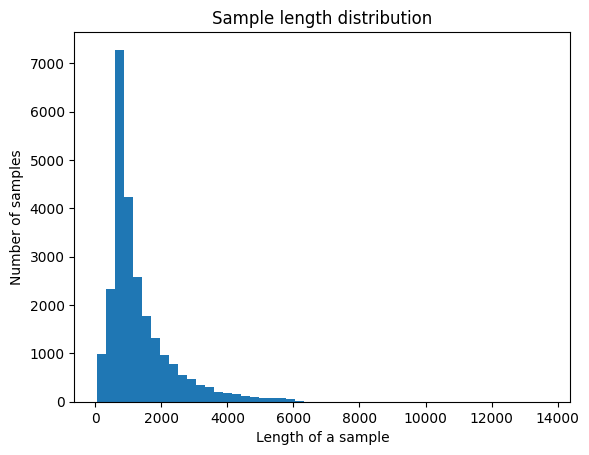

In [21]:
plot_sample_length_distributions(train_texts)

## Prepare Your Data

### N-gram vectors [Option A]

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MINIMUM_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
  """Vectorize texts as n-gram vectors.

  1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams

  # Arguments
      train_texts: list, training text strings.
      train_labels: np.ndarray, training labels.
      val_texts: list, validation text strings.

  # Returns
      x_train, x_val: vectorized training and validation texts
  """
  # Create keyword arguments to pass to the 'tf-idf' vectorizer.
  kwargs = {
      'ngram_range': NGRAM_RANGE, # Use 1-grams + 2-grams.
      'dtype': 'int32',
      'strip_accents': 'unicode',
      'decode_error': 'replace',
      'analyzer': TOKEN_MODE, # Split text into word tokens.
      'min_df': MINIMUM_DOCUMENT_FREQUENCY,
  }
  vectorizer = TfidfVectorizer(**kwargs)

  # Learn vocabulary from training texts and vectorize training texts.
  x_train = vectorizer.fit_transform(train_texts)

  # Vectorizer validation texts.
  x_val = vectorizer.transform(val_texts)

  # Select top 'k' of the vectorized features.
  selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
  selector.fit(x_train, train_labels)
  x_train = selector.transform(x_train).astype('float32')
  x_val = selector.transform(x_val).astype('float32')
  return x_train, x_val

### Sequence Vectors [Option B]

In [24]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequence longer than this
# will be truncated
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
  """Vectorize texts as sequence vectors.

  1 text = 1 sequence vector with fixed length.

  # Arguments
      train_texts: list, training text strings.
      val_texts: list, validation text strings.

  # Returns
      x_train, x_val, word_index: vectorized training and validation
          texts and word index dictionary.
  """
  # Create vocabulary with training texts.
  tokenizer = text.Tokenizer(num_words=TOP_K)
  tokenizer.fit_on_texts(train_texts)

  # Vectorize training and validation texts.
  x_train = tokenizer.texts_to_sequences(train_texts)
  x_val = tokenizer.texts_to_sequences(val_texts)

  # Get max sequence length.
  max_length = len(max(x_train, key=len))
  if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH

  # Fix sequence length to max value. Sequences shorter than the length are 
  # padded in the beginning and sequences longer are truncated
  # at the beginning.
  x_train = sequence.pad_sequences(x_train, maxlen=max_length)
  x_val = sequence.pad_sequences(x_val, maxlen=max_length)
  return x_train, x_val, tokenizer.word_index

## Constructing the Last Layer

In [25]:
def _get_last_layer_units_and_activation(num_classes):
  """Gets the # units and activation function for the last network layer.

  # Arguments
      num_classes: int, number of classes.

  # Returns
      units, activation values.
  """
  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes
  return units, activation

### Build n-gram model [Option A]

In [42]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
  """Create an instance of a multi-layer perceptron model.

  # Arguments
      layers: int, number of `Dense` layers in the model.
      units: int, output dimension of the layers.
      dropout_rate: float, percentage of input to drop at Dropout layers.
      input_shape: tuple, shape of input to the model
      num_classes: int, number of output classes.

  # Returns 
      An MLP model instance.
  """
  op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
  model = models.Sequential()
  # model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

  for _ in range(layers-1):
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))

  model.add(Dense(units=op_units, activation=op_activation))
  return model

### Build sequence model [Option B]

The following code constructs a four-layer sepCNN model:

In [54]:
from tensorflow import keras

def sepcnn_model(
    blocks, 
    filters,
    kernel_size,
    embedding_dim,
    dropout_rate,
    pool_size,
    input_shape,
    num_classes,
    num_features,
    use_pretrained_embedding=False,
    is_embedding_trainable=False,
    embedding_matrix=None):
  """Createas an instance of a separable CNN model.

  # Arguments
      blocks: int, number of pairs of sepCNN and pooling blocks in the model.
      filters: int, output dimension of the layers.
      kernel_size: int, length of the convolutional window.
      embedding_dim: int, dimension of the embedding vectors.
      dropout_rate: float, percentage of input to drop at Dropout layers.
      pool_size: int, factor by which to downscale input at MaxPooling layer.
      input_shape: tuple, shape of input to the model.
      num_classes: int, number of output classes.
      num_features: int, number of words (embedding input dimension).
      use_pretrained_embedding: bool, true if pre-trained embedding is on.
      is_embedding_trainable: bool, true if embedding layer is trainbale.
      embedding_matrix: dict, dictionary with embedding coefficients.
  
  # Returns
      A sepCNN model instance.
  """
  op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
  model = keras.models.Sequential()

  # Add embedding layer. If pre-trained embedding is used add weights to the
  # embeddings layer and set trainable to input is_embedding_trainable flag.
  if use_pretrained_embedding:
    model.add(keras.layers.Embedding(input_dim=num_features,
                                     outpu_dim=embedding_dim,
                                     input_length=input_shape[0],
                                     weights=[embedding_matrix],
                                     trainabel=is_embedding_trainable))
  else:
    model.add(keras.layers.Embedding(input_dim=num_features,
                        output_dim=embedding_dim,
                        input_length=input_shape[0]))
    
  for _ in range(blocks-1):
    model.add(Dropout(rate=dropout_rate))
    model.add(keras.layers.SeparableConv1D(filters=filters,
                                           kernel_size=kernel_size,
                                           activation='relu',
                                           bias_initializer='random_uniform',

                                           padding='same'))
    model.add(keras.layers.SeparableConv1D(filters=filters,
                                           kernel_size=kernel_size,
                                           activation='relu',
                                           bias_initializer='random_uniform',
                                           padding='same'))
    model.add(keras.layers.MaxPooling1D(pool_size=pool_size))

  model.add(keras.layers.SeparableConv1D(filters=filters * 2,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         padding='same'))
  model.add(keras.layers.SeparableConv1D(filters=filters * 2,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         padding='same'))
  model.add(keras.layers.GlobalAveragePooling1D())
  model.add(Dropout(rate=dropout_rate))
  model.add(keras.layers.Dense(op_units, activation=op_activation))
  return model

## Train Your Model

In [44]:
def train_ngram_model(data, 
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
  """Trains n-gram model on the given dataset.

  # Arguments
      data: tuples of training and test texts and labels.
      learning_rate: float, learning rate for training model.
      epochs: int, number of epochs,
      batch_size: int, number of samples per batch.
      layers: int, number of `Dense` layers in the model.
      units: int, output dimension of Dense layers in the model.
      dropout_rate: float, percentage of input to drop at Dropout layers.

  # Raises
      ValueError: If validation data has label values which were not seen 
          in the training data.
  """
  # Get the data.
  (train_texts, train_labels), (val_texts, val_labels) = data

  # Verify that validation labels are in the same range as training labels.
  num_classes = get_num_classes(train_labels)
  unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
  if len(unexpected_labels):
      raise ValueError('Unexpected label values found in the validation set:'
                        ' {unexpected_labels}. Please make sure that the '
                        'labels in the validation set are in the same range '
                        'as training labels.'.format(
                            unexpected_labels=unexpected_labels))
      
  # Vectorize texts.
  x_train, x_val = ngram_vectorize(
      train_texts, train_labels, val_texts)
  
  # Create model instance.
  model = mlp_model(layers=layers,
                                units=units,
                                dropout_rate=dropout_rate,
                                input_shape=x_train.shape[1:],
                                num_classes=num_classes)
  
  # Compile model with learning parameters.
  if num_classes == 2:
    loss = 'binary_crossentropy'
  else:
    loss = 'sparse_categorical_crossentropy'
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  # Create callback for early stopping on validation loss. If the loss does
  # not decrease in two consecutive tries, stop training.
  callbacks = [keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=2)]

  # Train and validate model.
  history = model.fit(
      x_train,
      train_labels,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=(x_val, val_labels),
      verbose=2, # Logs once per epochs.
      batch_size=batch_size)
  
  # Prints results.
  history = history.history
  print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_accuracy'][-1], loss=history['val_loss'][-1]))

  # Save model.
  model.save('IMDb_mlp_model.h5')
  return history['val_accuracy'][-1], history['val_loss'][-1]

In [45]:
train_ngram_model(data=((train_texts, train_labels), (test_texts, test_labels)))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:2072: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


Epoch 1/1000
196/196 - 7s - loss: 0.4637 - accuracy: 0.8627 - val_loss: 0.3159 - val_accuracy: 0.8891 - 7s/epoch - 34ms/step
Epoch 2/1000
196/196 - 6s - loss: 0.2190 - accuracy: 0.9282 - val_loss: 0.2466 - val_accuracy: 0.9029 - 6s/epoch - 30ms/step
Epoch 3/1000
196/196 - 6s - loss: 0.1521 - accuracy: 0.9488 - val_loss: 0.2329 - val_accuracy: 0.9048 - 6s/epoch - 32ms/step
Epoch 4/1000
196/196 - 6s - loss: 0.1163 - accuracy: 0.9630 - val_loss: 0.2300 - val_accuracy: 0.9057 - 6s/epoch - 31ms/step
Epoch 5/1000
196/196 - 5s - loss: 0.0905 - accuracy: 0.9746 - val_loss: 0.2352 - val_accuracy: 0.9039 - 5s/epoch - 26ms/step
Epoch 6/1000
196/196 - 6s - loss: 0.0710 - accuracy: 0.9828 - val_loss: 0.2443 - val_accuracy: 0.9016 - 6s/epoch - 28ms/step
Validation accuracy: 0.9016000032424927, loss: 0.2443353533744812


(0.9016000032424927, 0.2443353533744812)

In [48]:
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000


def train_sequence_model(data,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_accuracy'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('rotten_tomatoes_sepcnn_model.h5')
    return history['val_accuracy'][-1], history['val_loss'][-1]

In [ ]:
train_sequence_model(data=((train_texts, train_labels), (test_texts, test_labels)))

Epoch 1/1000
196/196 - 193s - loss: 0.6934 - acc: 0.4915 - val_loss: 0.6931 - val_acc: 0.5000 - 193s/epoch - 984ms/step
Epoch 2/1000
196/196 - 190s - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6932 - val_acc: 0.5000 - 190s/epoch - 969ms/step
Epoch 3/1000
196/196 - 187s - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6932 - val_acc: 0.5000 - 187s/epoch - 954ms/step


KeyError: ignored